In [1]:
import os

from dotenv import load_dotenv
load_dotenv()
import datasets
from datasets import DatasetDict
from datasets import load_dataset
import datasets
import torch
import json
from huggingface_hub import HfApi

In [2]:
import numpy as np
import numpy as np


from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset
import util
from scipy.stats import zscore

In [3]:
dataset_name = "loris3/stratified_10m_curriculum"
curriculum_name ="random.pt"
influence_output_dir = os.path.join("./influence", os.path.basename(dataset_name))

In [4]:
dataset = load_dataset(dataset_name)["train"]

In [5]:
curriculum = util.get_curriculum(dataset_name, curriculum_name)

In [6]:


df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
df.sort_index(axis=1)

df = df.reindex(sorted(df.columns, reverse=False), axis=1)
influence_cols = df.columns
df["total"] = df.sum(axis=1)
df[["text", "source","stage"]] = dataset.to_pandas()
df["document_lenght"] = df["text"].str.split().str.len()





In [7]:
# def replace_outliers_with_nan(series):
#     z_scores = zscore(series, nan_policy='omit')  # Calculate Z-Scores
#     return series.where((z_scores < 2) & (z_scores > -2), np.nan)  # Replace outliers with NaN


In [8]:

dff = df[list(df.columns[0:-5])+["stage"]].sort_values(by="stage")
# dff[dff.columns[0:-1]].apply(replace_outliers_with_nan)

In [9]:
dff[dff.columns[0:-1]].to_numpy().mean()

0.0030441748

In [10]:
dff.iloc[curriculum[0,:]]

,522,1044,1566,2088,2610,3132,3654,4176,4698,5220,stage
971842,0.000326,0.001827,0.001263,0.000526,0.001318,-0.001196,0.001563,0.000823,-0.000033,0.000544,C5: Written English
428796,0.000000,0.000000,0.000000,0.000000,0.022012,0.000000,0.000000,0.000000,0.000000,0.000000,C2: Children's Books
231734,0.003134,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,-0.004986,0.011735,0.002539,C1: Child Directed Speech
331296,0.013958,0.000000,0.041181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,C1: Child Directed Speech
415747,-0.001483,0.004447,0.000000,-0.001664,-0.003092,0.000000,-0.001732,0.000000,0.003595,-0.001862,C2: Children's Books
...,...,...,...,...,...,...,...,...,...,...,...
786739,0.000000,-0.002803,0.030875,0.024281,0.000000,0.004912,0.004548,0.000000,0.000000,0.000000,C3: Dialogue
510283,0.052510,0.000000,0.002567,0.019035,0.000000,-0.006814,0.000000,0.000000,0.000000,-0.006280,C3: Dialogue
1004323,0.004657,0.000000,-0.008536,0.019930,0.016531,-0.000298,-0.014254,0.004238,0.009642,0.000518,C5: Written English
708825,0.000000,0.012606,0.000000,0.000000,0.000000,0.000000,-0.004892,0.000000,-0.020397,-0.017391,C3: Dialogue


Text(0.5, 1.0, 'Per document, per stage')

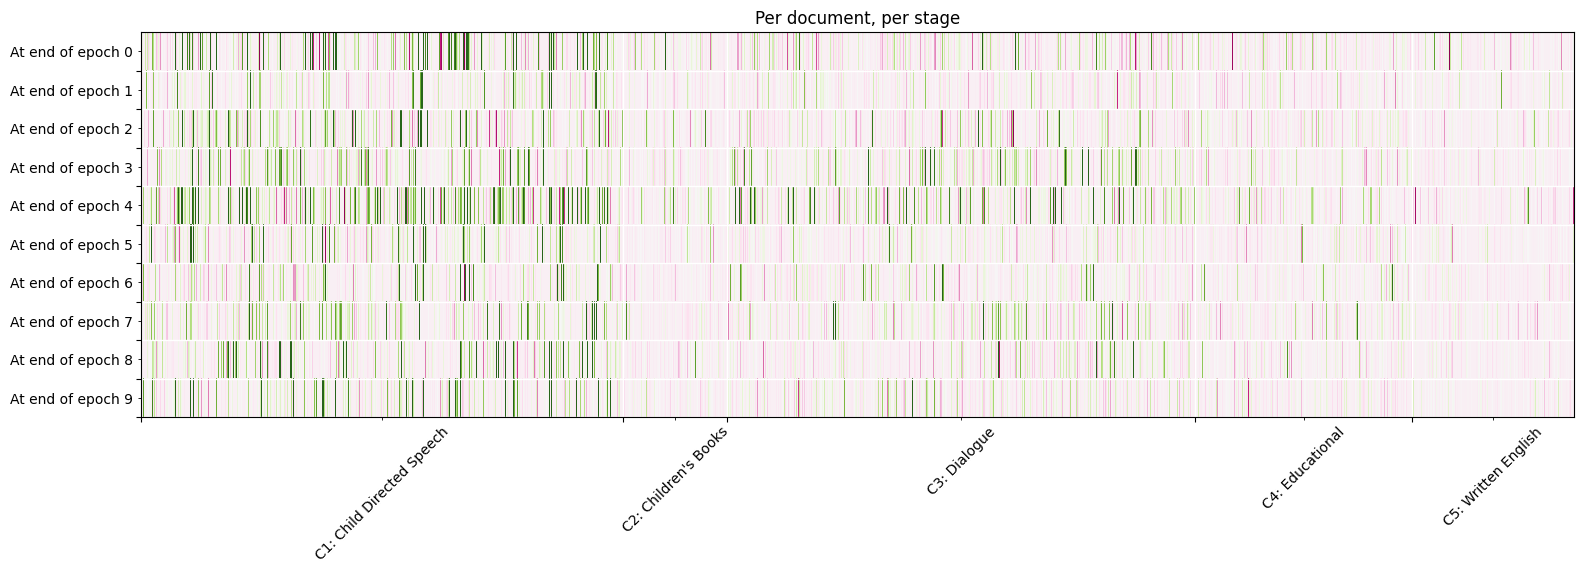

In [ ]:

dff = df[list(df.columns[0:-5])+["stage"]].sort_values(by="stage")
# dff[dff.columns[0:-1]] = dff[dff.columns[0:-1]].apply(replace_outliers_with_nan)

vc = dff.groupby(by="stage")["stage"].count()
counts = vc.to_numpy()
sources = vc.index.tolist()
ranges = [(start,stop) for start, stop in zip (np.cumsum(np.hstack((0,counts))),np.cumsum(counts))]
x_ticks,x_ticks_end = zip(*ranges)
out = np.empty((len(df.columns[0:-5]), len(df)))
for i, (source, (start,stop)) in enumerate(zip(sources, ranges)):
    # print(source, start, stop)
    # display(df[df["source"] == source][df.columns[0:-4]].to_numpy().T.shape)
    out[:,start:stop] = dff[dff["stage"] == source][dff.columns[0:-1]].to_numpy().T#.reshape(1, len(df))
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 5)


z = 3
plt.imshow(out,aspect="auto",interpolation="none", cmap="PiYG",
           vmin= out.mean() - z*out.std(),
           vmax= out.mean() + z*out.std()
           )
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)


ax.set_xticks(x_ticks, [], minor=False)
ax.set_xticks(np.array(x_ticks_end) - ((np.array(x_ticks_end)-np.array(x_ticks))/2)  , sources, minor=True, rotation=45)

ax.set_yticks(np.arange(0.5, len(dff.columns[0:-1]), 1), [], minor=False)
ax.set_yticks(np.arange(0.0, len(dff.columns[0:-1]), 1), ["At end of epoch {}".format(i) for i in np.arange(0, len(dff.columns[0:-1]))], minor=True)
ax.grid(color='w', linestyle='-', linewidth=1)

# ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.title("Per document, per stage/domain")

In [18]:
out.shape

(10, 9999925)

Text(0.5, 1.0, 'Per token ([doc]* tokes_doc)')

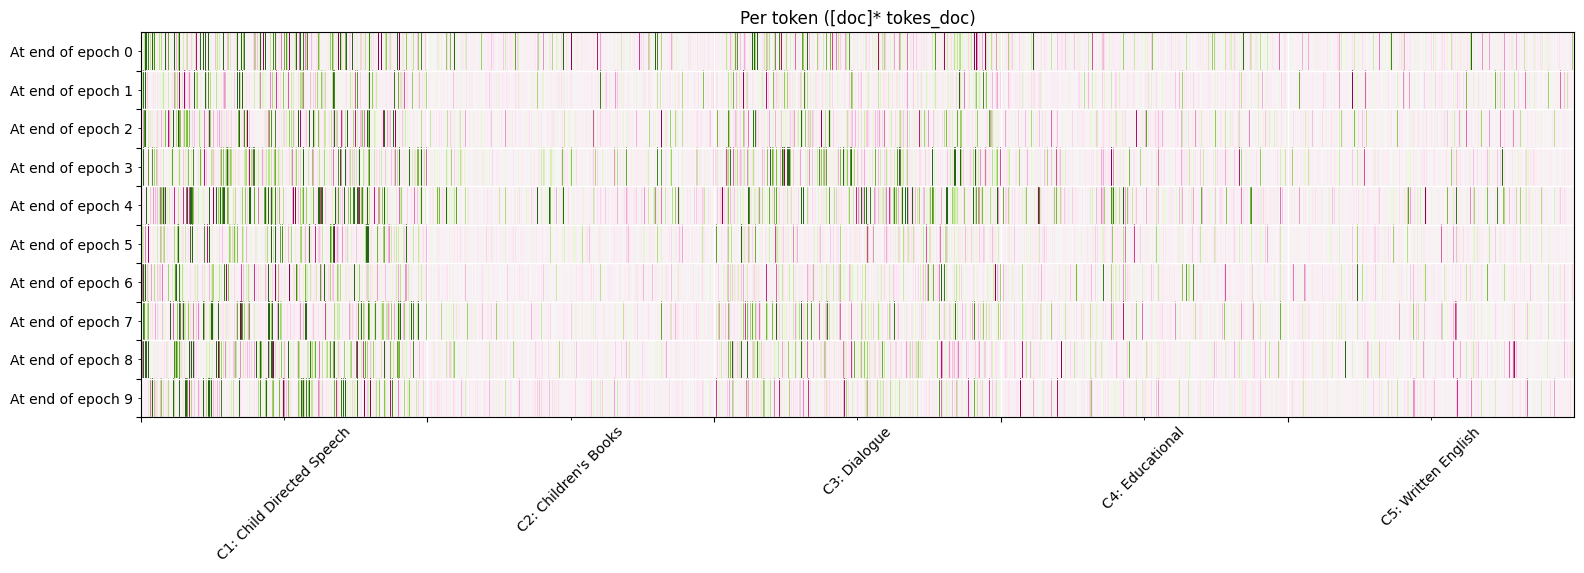

In [24]:

dff = df[list(df.columns[0:-5])+["stage", "document_lenght"]].sort_values(by="stage")
vc = dff.groupby(by="stage")["document_lenght"].sum()
counts = vc.to_numpy()
sources = vc.index.tolist()
ranges = [(start,stop) for start, stop in zip (np.cumsum(np.hstack((0,counts))),np.cumsum(counts))]




out = np.empty((len(df.columns[0:-5]), df["document_lenght"].sum()))
for i, (source, (start,stop)) in enumerate(zip(sources, ranges)):
    # print(source, start, stop)
    # display(df[df["source"] == source][df.columns[0:-4]].to_numpy().T.shape)
    a = df[df["stage"] == source][df.columns[0:-5]].to_numpy().T
    dl = df[df["stage"] == source]["document_lenght"].to_numpy().T
    
    for j in range(0, a.shape[0]):
        out[j,start:stop] = np.repeat(a[j],dl, axis=0)



import matplotlib.pyplot as plt

chunk_size = 2  # Size of chunks
new_length = out.shape[1] // chunk_size
downsampled = out[:, :new_length * chunk_size].reshape(out.shape[0], new_length, chunk_size).mean(axis=2)

fig = plt.gcf()
fig.set_size_inches(18.5, 5)


out = downsampled
z = 3
plt.imshow(out,aspect="auto",interpolation="none", cmap="PiYG",
           vmin= out.mean() - z*out.std(),
           vmax= out.mean() + z*out.std()
           )



ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

x_ticks,x_ticks_end = zip(*[(start//chunk_size,stop//chunk_size) for start, stop in ranges])


ax.set_xticks(x_ticks, [], minor=False)
ax.set_xticks(np.array(x_ticks_end) - ((np.array(x_ticks_end)-np.array(x_ticks))/2)  , sources, minor=True, rotation=45)

ax.set_yticks(np.arange(0.5, len(df.columns[0:-5]), 1), [], minor=False)
ax.set_yticks(np.arange(0.0, len(df.columns[0:-5]), 1), ["At end of epoch {}".format(i) for i in np.arange(0, len(df.columns[0:-5]))], minor=True)
ax.grid(color='w', linestyle='-', linewidth=1)

# ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title("Per token ([doc]* tokes_doc)")


In [20]:
dff.iloc[curriculum[i,:].numpy(),i]

663492     0.006418
458718     0.004853
957156     0.000000
683556     0.000000
190216     0.004438
             ...   
452624     0.000000
650346     0.000000
421660     0.002459
388356     0.000130
1050598    0.000000
Name: 2610, Length: 1070321, dtype: float32

In [21]:
len(dff)

1070321

Text(0.5, 1.0, 'Per document in order')

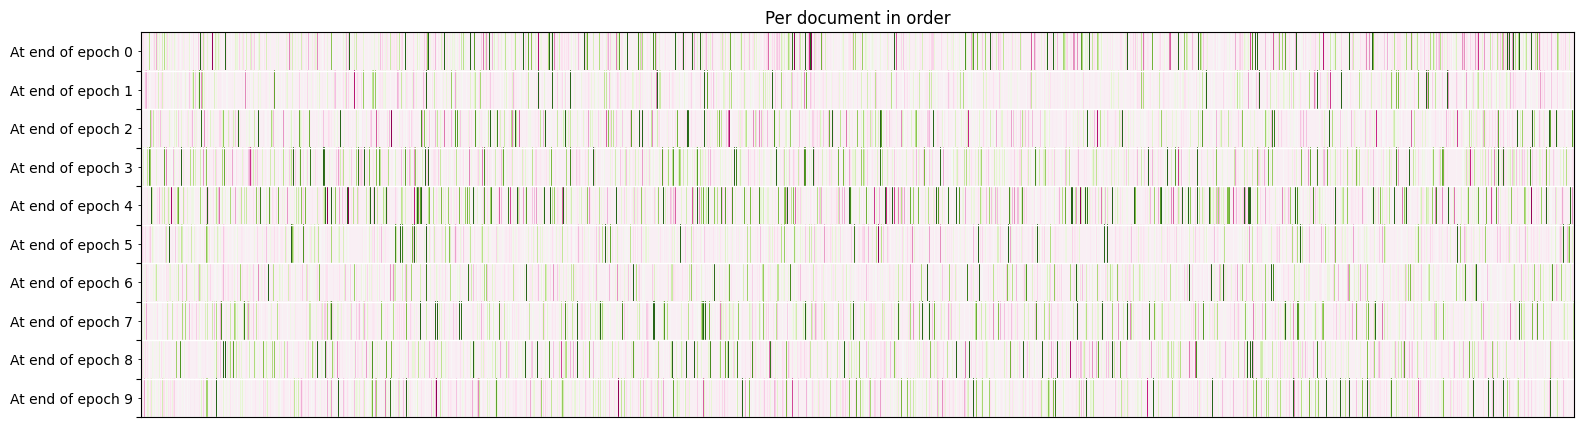

In [23]:

dff = df[list(df.columns[0:-5])]


out = np.empty((len(df.columns[0:-5]), len(dff)))
for i in range(0, len(dff.columns)):
    out[i,:] = dff.iloc[curriculum[i,:].numpy(),i]



import matplotlib.pyplot as plt


fig = plt.gcf()
fig.set_size_inches(18.5, 5)



z = 3
plt.imshow(out,aspect="auto",interpolation="none", cmap="PiYG",
           vmin= out.mean() - z*out.std(),
           vmax= out.mean() + z*out.std()
           )


ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

ax.set_xticks([], [], minor=False)

ax.set_yticks(np.arange(0.5, len(df.columns[0:-5]), 1), [], minor=False)
ax.set_yticks(np.arange(0.0, len(df.columns[0:-5]), 1), ["At end of epoch {}".format(i) for i in np.arange(0, len(df.columns[0:-5]))], minor=True)
ax.grid(color='w', linestyle='-', linewidth=1)
plt.title("Per document in order")
# ax.get_yaxis().get_major_formatter().set_scientific(False)



In [46]:
out[j,:].shape

(9999925,)

In [51]:
dl.shape

(1070321,)

In [47]:
np.repeat(a[j],dl, axis=0).shape

ValueError: operands could not be broadcast together with shape (1,) (1070321,)

In [68]:
dl.shape

(1070321,)

Text(0.5, 1.0, 'Per token ([doc]* tokes_doc)')

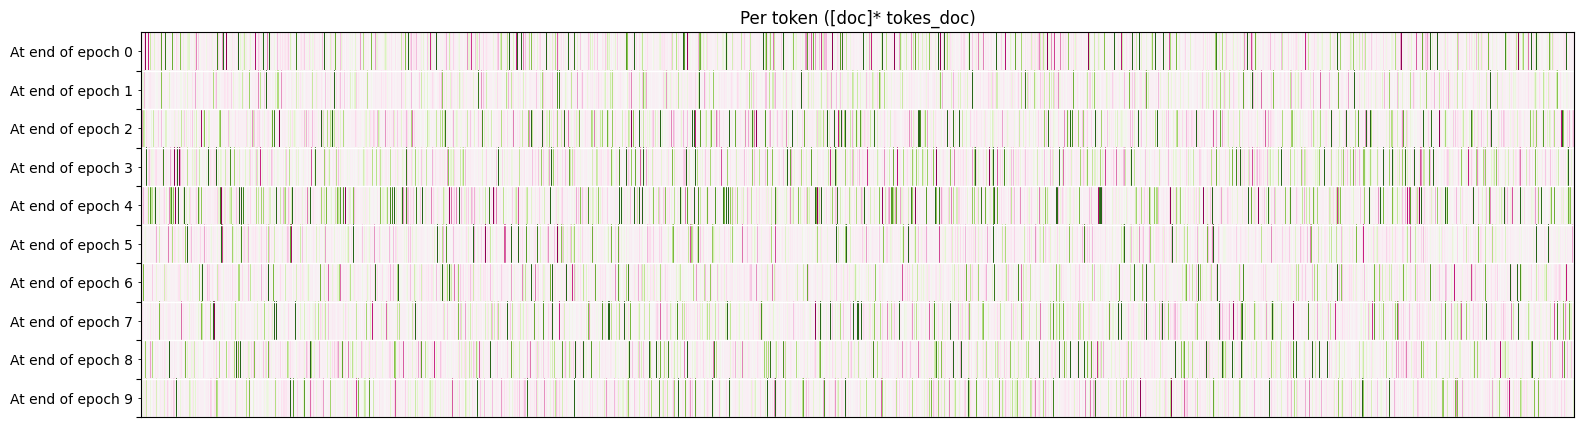

In [72]:

dff = df[list(df.columns[0:-5])+[ "document_lenght"]]



out = np.empty((len(df.columns[0:-5]), df["document_lenght"].sum()))
for i in range(0, len(df.columns[0:-5])):
    # print(source, start, stop)
    # display(df[df["source"] == source][df.columns[0:-4]].to_numpy().T.shape)
    a = dff.iloc[curriculum[i,:].numpy(),i].to_numpy().T
    dl = dff["document_lenght"].iloc[curriculum[i,:].numpy()].to_numpy().T
    out[i,:] = np.repeat(a,dl, axis=0)



import matplotlib.pyplot as plt

chunk_size = 2  # Size of chunks
new_length = out.shape[1] // chunk_size
downsampled = out[:, :new_length * chunk_size].reshape(out.shape[0], new_length, chunk_size).mean(axis=2)

fig = plt.gcf()
fig.set_size_inches(18.5, 5)


out = downsampled
z = 3
plt.imshow(out,aspect="auto",interpolation="none", cmap="PiYG",
           vmin= out.mean() - z*out.std(),
           vmax= out.mean() + z*out.std()
           )



ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

x_ticks,x_ticks_end = zip(*[(start//chunk_size,stop//chunk_size) for start, stop in ranges])


ax.set_xticks([], [], minor=False)


ax.set_yticks(np.arange(0.5, len(df.columns[0:-5]), 1), [], minor=False)
ax.set_yticks(np.arange(0.0, len(df.columns[0:-5]), 1), ["At end of epoch {}".format(i) for i in np.arange(0, len(df.columns[0:-5]))], minor=True)
ax.grid(color='w', linestyle='-', linewidth=1)

# ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title("Per token ([doc]* tokes_doc)")
